### Carga de librerias

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

### Importacion de datos

In [2]:
df_train = pd.read_csv('abalone_train.csv', delimiter = ',')
df_test = pd.read_csv('abalone_test.csv', delimiter = ',')

### Parte 1: Análisis exploratorio de datos

In [3]:
# i. ¿Cuántos datos tenemos para nuestro análisis?
df_train.shape
# 3342 filas por 9 columnas

(3342, 9)

In [4]:
#ii. Encontrar estadísticas descriptivas de todas las variables de
#la base de datos. Entre ellas, deben estar: media, desviación
#estándar, mínimo, máximo, percentiles 25, 50 y 75.
df_train.describe()

,longitud,diametro,altura,peso_entero,peso_sin_cascara,peso_visceras,peso_cascara,edad
count,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000
mean,0.522362,0.406858,0.139461,0.823557,0.355899,0.179492,0.238495,10.040694
std,0.120648,0.099741,0.042764,0.491525,0.221827,0.109655,0.141137,3.335768
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.345000,0.115000,0.438000,0.182000,0.092500,0.127875,8.000000
50%,0.540000,0.425000,0.140000,0.795750,0.332000,0.169250,0.230000,10.000000
75%,0.615000,0.480000,0.165000,1.145000,0.497000,0.249875,0.325000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [5]:
df_train.describe(include = 'object')

,sexo
count,3342
unique,3
top,M
freq,1233


In [6]:
# la variable sexo(unica categorica), tiene 3 valores unicos, siendo la major frecuente el femenino con 1233 ocurrencias.
# ¿Cual es el tercer sexo?
set(df_train['sexo'])
#I: indefinido

{'F', 'I', 'M'}

In [7]:
#¿Valores nulos?
df_train.info()
#No hay nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sexo              3342 non-null   object 
 1   longitud          3342 non-null   float64
 2   diametro          3342 non-null   float64
 3   altura            3342 non-null   float64
 4   peso_entero       3342 non-null   float64
 5   peso_sin_cascara  3342 non-null   float64
 6   peso_visceras     3342 non-null   float64
 7   peso_cascara      3342 non-null   float64
 8   edad              3342 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 235.1+ KB


In [8]:
#Otra manera de ver
df_train.isnull().sum()

sexo                0
longitud            0
diametro            0
altura              0
peso_entero         0
peso_sin_cascara    0
peso_visceras       0
peso_cascara        0
edad                0
dtype: int64

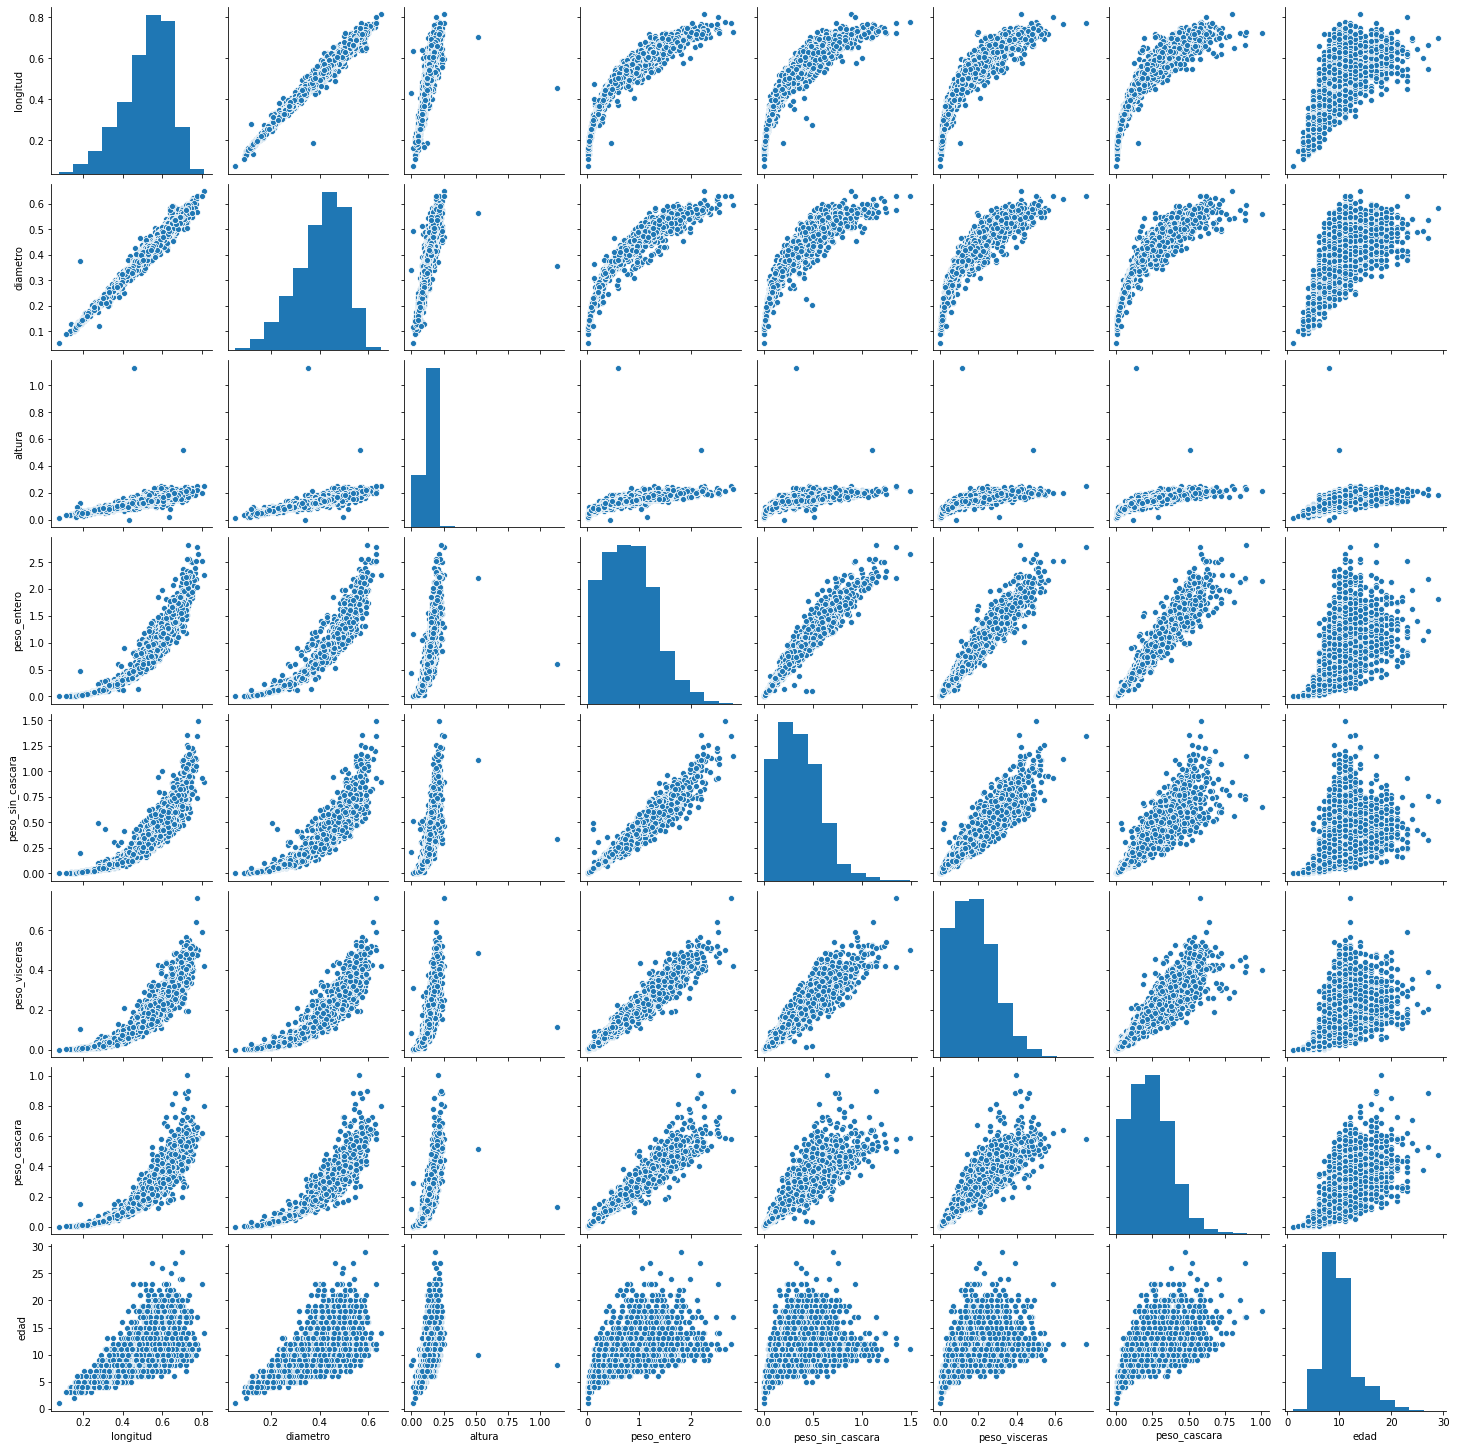

In [9]:
#iii. Búsqueda de variables mas importantes para construir el modelo
sns.pairplot(df_train)

<AxesSubplot:xlabel='edad', ylabel='altura'>

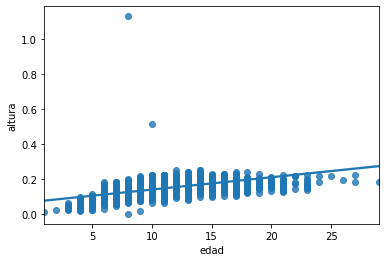

In [10]:
#En este grafico, todas las variables salvo altura, tienen fuertes correlaciones con Edad.
#Se hara un grafico de regresion de altura v/s edad
sns.regplot(data = df_train, x = 'edad', y = 'altura')
#Se observa que no es significativa la altura con el avance de la edad. 
#Se puede conjeturar que a la edad de 6 años ya alcanza
#su altura promedio y que esta no varia conforme pasa el tiempo.

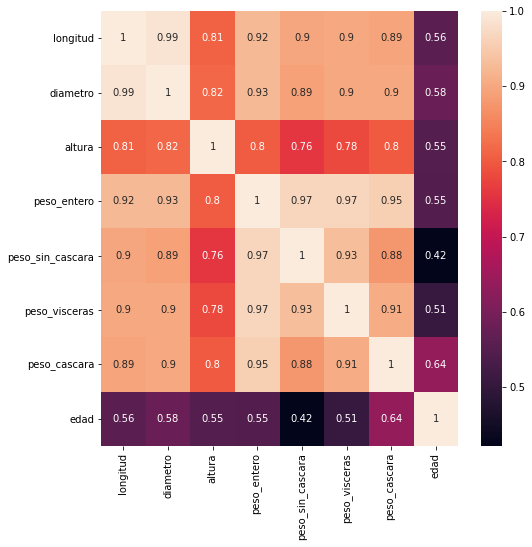

In [11]:
# A continuacion, un mapa de calor puede darnos mas información.
correlacion_train = df_train.corr()
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(correlacion_train, annot = True)
plt.show()

In [12]:
#Sorpresa es lo que muestra el mapa de calor pues como se veia graficamente que la variable Altura no mostraba una gran correlacion
#grafica, la variable menos fuerte en este caso es peso_sin_cascara. Sin embargo todas son parejamente correlacionadas.
#Para el modelo puede calcularse las metricas con y sin peso_sin_cascara.

<AxesSubplot:xlabel='sexo', ylabel='edad'>

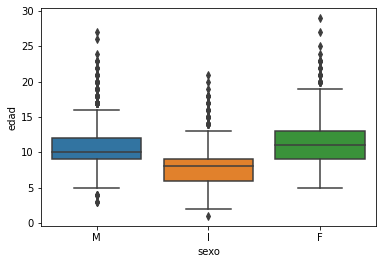

In [13]:
# Grafico de caja y bigote
sns.boxplot(data=df_train, x = 'sexo', y = 'edad')
# En este caso, la jnica variable categorica es sexo. El sexo mas longevo es el femenino

In [14]:
# Para ver numericamente el sexo mas longevo, es recomendable hacer un group by
df_train.groupby('sexo').mean()
# Con esto queda demostrado que el sexo femenino en esta muestra es quien tiene mas edad en promedio.
# Además se puede tambien mostrar que en el resto de las variables, el sexo femenino es superior al masculino y 
# a los no definidos

,longitud,diametro,altura,peso_entero,peso_sin_cascara,peso_visceras,peso_cascara,edad
sexo,,,,,,,,
F,0.576098,0.452322,0.157701,1.033271,0.438700,0.227446,0.299690,11.272897
I,0.424986,0.324427,0.107377,0.424676,0.188345,0.090859,0.126053,7.881617
M,0.557786,0.436865,0.150669,0.977689,0.425236,0.212564,0.280139,10.790754


### Proyecto parte 2: métricas de desempeño de un modelo

In [15]:
df_test.head()

,sexo,longitud,diametro,altura,peso_entero,peso_sin_cascara,peso_visceras,peso_cascara,edad,modelo_2,modelo_3
0,M,0.430,0.330,0.095,0.340,0.1315,0.085,0.1120,14,16.98,15.13
1,F,0.455,0.365,0.110,0.385,0.1660,0.046,0.1345,13,20.73,16.38
2,I,0.495,0.380,0.145,0.515,0.1750,0.098,0.2120,13,18.43,13.51
3,F,0.480,0.380,0.145,0.590,0.2320,0.141,0.2300,12,17.72,14.71
4,I,0.470,0.400,0.160,0.510,0.1615,0.073,0.1980,14,17.66,16.27


In [53]:
df_test.shape

(835, 11)

In [16]:
"""
1. Grafica la variable edad contra la edad predicha en cada
modelo (haz un gráfico separado para el modelo_2 y para el
modelo_3). ¿Qué modelo pareciera ser mejor cuando se hace el
análisis gráfico?
"""

'\n1. Grafica la variable edad contra la edad predicha en cada\nmodelo (haz un gráfico separado para el modelo_2 y para el\nmodelo_3). ¿Qué modelo pareciera ser mejor cuando se hace el\nanálisis gráfico?\n'

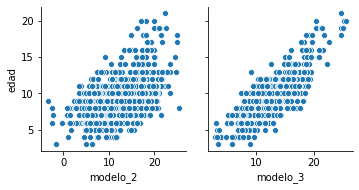

In [19]:
sns.pairplot(data=df_test, x_vars=['modelo_2', 'modelo_3'], y_vars = 'edad')
plt.show()
# Considerando estos graficos, el modelo 3 al tener menos dispersion de sus datos, tiene mejores resultados versus el modelo 2

In [20]:
"""
2. Calcular las métricas RMSE, MAE y MAPE para los dos
modelos y construir una tabla que permita comparar los dos
modelos. 
"""

'\n2. Calcular las métricas RMSE, MAE y MAPE para los dos\nmodelos y construir una tabla que permita comparar los dos\nmodelos. \n'

In [32]:
linear_univ_mod_2 = LinearRegression().fit(df_test[['edad']], df_test[['modelo_2']])
RMSE_m2 = mean_squared_error(df_test[['edad']], df_test[['modelo_2']], squared=False)
MAE_m2 = mean_absolute_error(df_test[['edad']], df_test[['modelo_2']])
MAPE_m2 = mean_absolute_percentage_error(df_test[['edad']], df_test[['modelo_2',]])
print("RMSE_m2 = {}".format(round(RMSE_m2, 2)))
print("MAE_m2 = {}".format(round(MAE_m2, 2)))
print("MAPE_2 = {}".format(round(MAPE_m2, 2)))

RMSE_m2 = 5.0
MAE_m2 = 4.04
MAPE_2 = 0.47


In [33]:
linear_univ_mod_3 = LinearRegression().fit(df_test[['edad']], df_test[['modelo_3']])
RMSE_m3 = mean_squared_error(df_test[['edad']], df_test[['modelo_3']], squared=False)
MAE_m3 = mean_absolute_error(df_test[['edad']], df_test[['modelo_3']])
MAPE_m3 = mean_absolute_percentage_error(df_test[['edad']], df_test[['modelo_3',]])
print("RMSE_m3 = {}".format(round(RMSE_m3, 2)))
print("MAE_m3 = {}".format(round(MAE_m3, 2)))
print("MAPE_m3 = {}".format(round(MAPE_m3, 2)))

RMSE_m3 = 3.58
MAE_m3 = 3.1
MAPE_m3 = 0.35


In [41]:
modelos = {'m2':[RMSE_m2, MAE_m2,MAPE_m2], 'm3':[RMSE_m3, MAE_m3,MAPE_m3]}
labels = ['RMSE', 'MAE', 'MAPE']
resumen = pd.DataFrame(modelos, index = labels)

In [42]:
resumen
# Se demuestra que el modelo 3, tiene mejor prediccion que el modelo 2

,m2,m3
RMSE,5.004019,3.577301
MAE,4.044826,3.096084
MAPE,0.470583,0.350680


In [52]:
# En resumen: En promedio, el error que tendríamos a la hora de predecir la la edad de un abalón es de +/- 3.096 años, 
# que en terminos porcentuales es un 35.07%.
# Teniendo en cuenta esto, el modelo_3 estaría en la categoría de "predicción razonable" con un MAPE entre el 20-50%

### Parte 3: Proyecto final

In [54]:
# La variable sexo al ser categorica, se haran variables dummy para cada sexo. 
# El punto es ver si el sexo, en un heatmap, resulta ser considerable de tener en cuenta para el modelo predictivo

In [134]:
# Se hará la prueba en df_train.
dummy_sexo = pd.get_dummies(df_train['sexo'], prefix = 'sexo_')

In [135]:
df_train1 = pd.concat([df_train, dummy_sexo], axis = 1)

In [136]:
df_train1.head()

,sexo,longitud,diametro,altura,peso_entero,peso_sin_cascara,peso_visceras,peso_cascara,edad,peso_casc_sq,sexo__F,sexo__I,sexo__M
0,M,0.620,0.490,0.155,1.1000,0.5050,0.2475,0.3100,9,0.096100,0,0,1
1,I,0.475,0.375,0.110,0.4560,0.1820,0.0990,0.1600,9,0.025600,0,1,0
2,M,0.600,0.475,0.175,1.1100,0.5105,0.2560,0.2850,9,0.081225,0,0,1
3,I,0.340,0.255,0.075,0.1800,0.0745,0.0400,0.0525,6,0.002756,0,1,0
4,F,0.670,0.505,0.205,1.3645,0.6075,0.3025,0.3530,9,0.124609,1,0,0


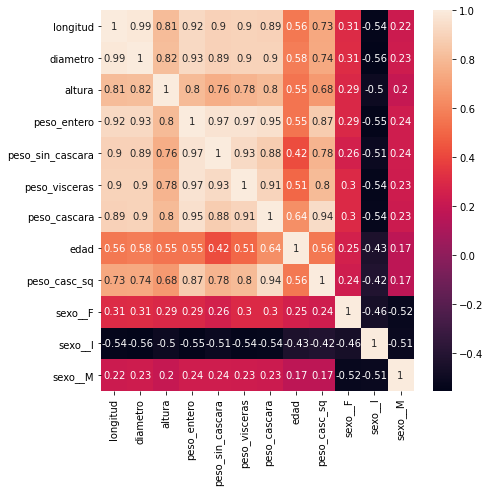

In [137]:
f,ax = plt.subplots(figsize= (7,7))
sns.heatmap(df_train1.corr(), annot = True)
plt.show()
#Segun los coeficientes de correlacion, no encuentro pertinente sumar a esta variable para predecir la edad de los abalones.

### Modelos sin metodo cuadratico

In [64]:
# Modelo lineal univariado (variable mas fuerte: peso_cascara v/s edad)

In [153]:
linear_univ_mod_4 = LinearRegression().fit(df_train[['peso_cascara']], df_train[['edad']])
df_test[['predicted_linear_univ_peso']] = pd.DataFrame(linear_univ_mod_4.predict(df_test[['peso_cascara']]))

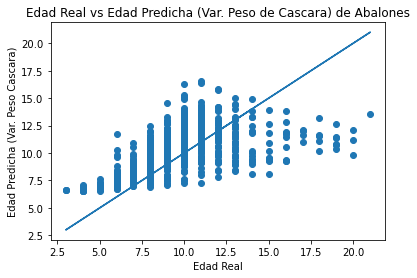

In [154]:
# Grafico
plt.scatter(df_test['edad'], df_test['predicted_linear_univ_peso'])
plt.plot(df_test[['edad']].values,df_test[['edad']].values)
plt.title("Edad Real vs Edad Predicha (Var. Peso de Cascara) de Abalones")
plt.xlabel("Edad Real")
plt.ylabel("Edad Predicha (Var. Peso Cascara)")
plt.show()

In [155]:
#Calculo de parametros
RMSE_m4 = mean_squared_error(df_test[['edad']], df_test[['predicted_linear_univ_peso']], squared=False)
MAE_m4 = mean_absolute_error(df_test[['edad']], df_test[['predicted_linear_univ_peso']])
MAPE_m4 = mean_absolute_percentage_error(df_test[['edad']], df_test[['predicted_linear_univ_peso']])
print("RMSE_m4 = {}".format(round(RMSE_m4, 2)))
print("MAE_m4 = {}".format(round(MAE_m4, 2)))
print("MAPE_m4 = {}".format(round(MAPE_m4, 2)))

RMSE_m4 = 2.27
MAE_m4 = 1.73
MAPE_m4 = 0.19


In [156]:
columnas = ['altura','diametro','longitud', 'peso_cascara','peso_entero','peso_sin_cascara','peso_visceras']

In [157]:
linear_univ_mod_5 = LinearRegression().fit(df_train[columnas], df_train[['edad']])
df_test[['predicted_linear_multi']] = pd.DataFrame(linear_univ_mod_5.predict(df_test[columnas]))

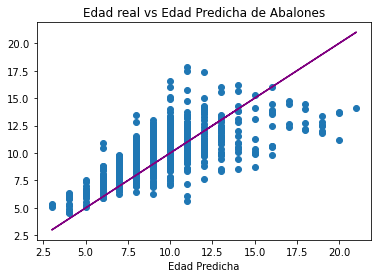

In [158]:
plt.scatter(df_test[['edad']], df_test[['predicted_linear_multi']])
plt.plot(df_test[['edad']].values, df_test[['edad']].values, color = 'purple')
plt.title("Edad real vs Edad Predicha de Abalones")
plt.xlabel("Edad real")
plt.xlabel("Edad Predicha")
plt.show()

In [159]:
#Calculo de parametros
RMSE_m5 = mean_squared_error(df_test[['edad']], df_test[['predicted_linear_multi']], squared=False)
MAE_m5 = mean_absolute_error(df_test[['edad']], df_test[['predicted_linear_multi']])
MAPE_m5 = mean_absolute_percentage_error(df_test[['edad']], df_test[['predicted_linear_multi']])
print("RMSE_m5 = {}".format(round(RMSE_m5, 2)))
print("MAE_m5 = {}".format(round(MAE_m5, 2)))
print("MAPE_m5 = {}".format(round(MAPE_m5, 2)))

RMSE_m5 = 2.02
MAE_m5 = 1.54
MAPE_m5 = 0.17


In [160]:
### Random Forests (todas las variables fuertes v/s edad)

In [161]:
mod_random_for = RandomForestRegressor(n_estimators = 100, max_depth = 5).fit(df_train[columnas], 
                                                                              df_train[['edad']].values.ravel())
df_test[['predicted_random_m6']] = pd.DataFrame(mod_random_for.predict(df_test[columnas]))

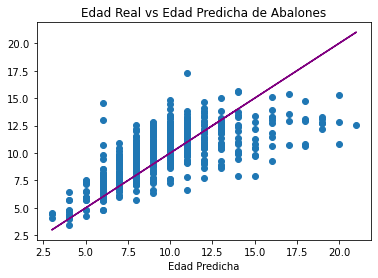

In [162]:
plt.scatter(df_test[['edad']], df_test[['predicted_random_m6']])
plt.plot(df_test[['edad']].values, df_test[['edad']].values, color = 'purple')
plt.title("Edad Real vs Edad Predicha de Abalones")
plt.xlabel("Edad Real")
plt.xlabel("Edad Predicha")
plt.show()

In [163]:
#Calculo de parametros
RMSE_m6 = mean_squared_error(df_test[['edad']], df_test[['predicted_random_m6']], squared=False)
MAE_m6 = mean_absolute_error(df_test[['edad']], df_test[['predicted_random_m6']])
MAPE_m6 = mean_absolute_percentage_error(df_test[['edad']], df_test[['predicted_random_m6']])
print("RMSE_m6 = {}".format(round(RMSE_m6, 2)))
print("MAE_m6 = {}".format(round(MAE_m6, 2)))
print("MAPE_m6 = {}".format(round(MAPE_m6, 2)))

RMSE_m6 = 1.96
MAE_m6 = 1.45
MAPE_m6 = 0.16


In [164]:
modelos = {'Regresion Lineal Simple':[RMSE_m4, MAE_m4,MAPE_m4], 'Regresion Lineal Multivariada':[RMSE_m5, MAE_m5,MAPE_m5], 
           'Regresion Random Forest':[RMSE_m6, MAE_m6,MAPE_m6]}
labels = ['RMSE', 'MAE', 'MAPE']
resumen1 = pd.DataFrame(modelos, index = labels)

In [165]:
resumen1
# Resultados de modelo sin término cuadratico.
# La regresion por random forest es la que arroja mejores resultados con un MAPE DE 15% de dispersion.

,Regresion Lineal Simple,Regresion Lineal Multivariada,Regresion Random Forest
RMSE,2.267434,2.021713,1.960598
MAE,1.726799,1.540191,1.450468
MAPE,0.188450,0.166195,0.155932


### Metodos con metodo cuadratico

In [166]:
# Regresion lineal univariada cuadratica

In [167]:
df_train[['peso_casc_sq']] = df_train[['peso_cascara']]*df_train[['peso_cascara']]
linear_cuad = LinearRegression().fit(df_train[['peso_cascara', 'peso_casc_sq']], df_train[['edad']])

df_test[['peso_casc_sq']] = df_test[['peso_cascara']]*df_test[['peso_cascara']]
df_test[['predicted_linear_sq']] = pd.DataFrame(linear_cuad.predict(df_test[['peso_cascara', 'peso_casc_sq']]))

#Calculo de parametros
RMSE_m7 = mean_squared_error(df_test[['edad']], df_test[['predicted_linear_sq']], squared=False)
MAE_m7 = mean_absolute_error(df_test[['edad']], df_test[['predicted_linear_sq']])
MAPE_m7 = mean_absolute_percentage_error(df_test[['edad']], df_test[['predicted_linear_sq']])
print("RMSE_m7 = {}".format(round(RMSE_m7, 2)))
print("MAE_m7 = {}".format(round(MAE_m7, 2)))
print("MAPE_m7 = {}".format(round(MAPE_m7, 2)))

RMSE_m7 = 2.23
MAE_m7 = 1.72
MAPE_m7 = 0.19


In [168]:
df_train.columns

Index(['sexo', 'longitud', 'diametro', 'altura', 'peso_entero',
       'peso_sin_cascara', 'peso_visceras', 'peso_cascara', 'edad',
       'peso_casc_sq'],
      dtype='object')

In [169]:
# Regresion lineal multivariada cuadratica

In [170]:
columnas_sq = ['altura','diametro','longitud', 'peso_cascara','peso_entero','peso_sin_cascara','peso_visceras','peso_casc_sq']
linear_multi_sq = LinearRegression().fit(df_train[columnas_sq], df_train[['edad']])
df_test[['predicted_linear_multi_sq']] = pd.DataFrame(linear_multi_sq.predict(df_test[columnas_sq]))

#Calculo de parametros
RMSE_m8 = mean_squared_error(df_test[['edad']], df_test[['predicted_linear_multi_sq']], squared=False)
MAE_m8 = mean_absolute_error(df_test[['edad']], df_test[['predicted_linear_multi_sq']])
MAPE_m8 = mean_absolute_percentage_error(df_test[['edad']], df_test[['predicted_linear_multi_sq']])
print("RMSE_m8 = {}".format(round(RMSE_m8, 2)))
print("MAE_m8 = {}".format(round(MAE_m8, 2)))
print("MAPE_m8 = {}".format(round(MAPE_m8, 2)))

RMSE_m8 = 2.0
MAE_m8 = 1.53
MAPE_m8 = 0.17


In [171]:
# Regresion por random forest cuadratico

In [172]:
columnas_sq = ['altura','diametro','longitud', 'peso_cascara','peso_entero','peso_sin_cascara','peso_visceras','peso_casc_sq']
mod_random_for_sq = RandomForestRegressor().fit(df_train[columnas_sq], df_train[['edad']].values.ravel())
df_test[['predicted_random_sq']] = pd.DataFrame(mod_random_for_sq.predict(df_test[columnas_sq]))

#Calculo de parametros
RMSE_m9 = mean_squared_error(df_test[['edad']], df_test[['predicted_random_sq']], squared=False)
MAE_m9 = mean_absolute_error(df_test[['edad']], df_test[['predicted_random_sq']])
MAPE_m9 = mean_absolute_percentage_error(df_test[['edad']], df_test[['predicted_random_sq']])
print("RMSE_m9 = {}".format(round(RMSE_m9, 2)))
print("MAE_m9 = {}".format(round(MAE_m9, 2)))
print("MAPE_m9 = {}".format(round(MAPE_m9, 2)))

RMSE_m9 = 2.0
MAE_m9 = 1.48
MAPE_m9 = 0.16


In [173]:
modelos1 = {'RL_sq':[RMSE_m7, MAE_m7,MAPE_m7], 'RLM_sq':[RMSE_m8, MAE_m8,MAPE_m8], 
           'RRF_sq':[RMSE_m9, MAE_m9,MAPE_m9]}
labels = ['RMSE', 'MAE', 'MAPE']
resumen2 = pd.DataFrame(modelos1, index = labels)

In [174]:
resumen2

,RL_sq,RLM_sq,RRF_sq
RMSE,2.232156,2.003507,1.997085
MAE,1.722162,1.530363,1.481377
MAPE,0.185074,0.165836,0.159577


In [175]:
completo = pd.concat([resumen1,resumen2], axis = 1)

In [176]:
completo

,Regresion Lineal Simple,Regresion Lineal Multivariada,Regresion Random Forest,RL_sq,RLM_sq,RRF_sq
RMSE,2.267434,2.021713,1.960598,2.232156,2.003507,1.997085
MAE,1.726799,1.540191,1.450468,1.722162,1.530363,1.481377
MAPE,0.188450,0.166195,0.155932,0.185074,0.165836,0.159577


En la tabla comparativa, se demuestra que las regresiones normales y cuadraticas de Ramdom Forests dan mejores predicciones
que las regresiones simples y multivariadas normales y cuadraticas